In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [20]:
date_previous='2005-01-01'
date_today='2019-12-31'
data = yf.download(tickers ='EURUSD=X',start =date_previous,end =date_today,interval= '1d' )

[*********************100%***********************]  1 of 1 completed


In [21]:
data_close = data.filter(['Close'])
dataset = data_close.values

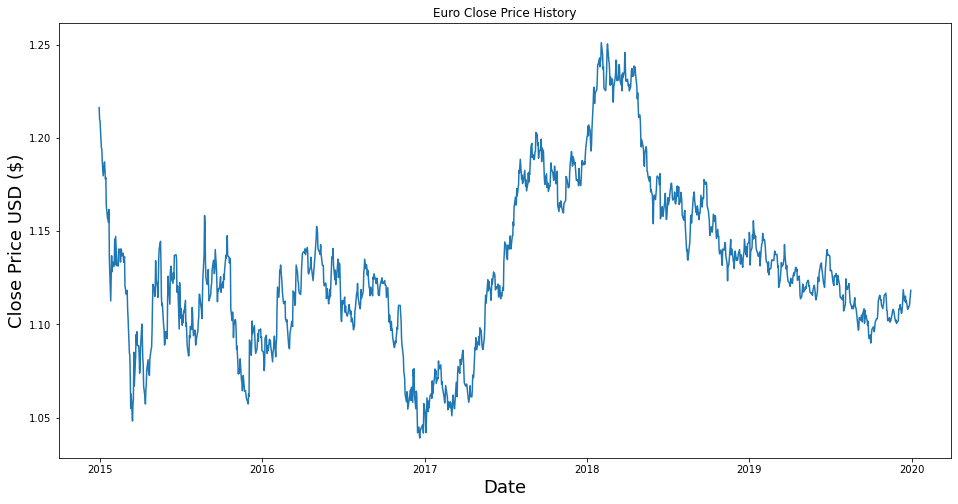

In [35]:
plt.figure(figsize=(16,8))
plt.title('Euro Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [23]:
train_len = math.ceil( len(dataset) *.8)

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
training_data = scaler.fit_transform(dataset[:train_len , : ])

In [25]:
x_train =[]
y_train =[]
for i in range(60, len(training_data)):
  x_train.append(training_data[i-60:i,0])
  y_train.append(training_data[i,0])

In [26]:
x_train,y_train = np.array(x_train), np.array(y_train)
x_train= np.reshape(x_train,( x_train.shape[0] ,x_train.shape[1] ,1))

In [27]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM( 50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.save('lstm_model.h5')

In [32]:
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
31/31 [==============================] - 2s 77ms/step - loss: 0.0065
Epoch 2/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0051
Epoch 3/100
31/31 [==============================] - 2s 56ms/step - loss: 0.0047
Epoch 4/100
31/31 [==============================] - 2s 54ms/step - loss: 0.0045
Epoch 5/100
31/31 [==============================] - 2s 54ms/step - loss: 0.0045
Epoch 6/100
31/31 [==============================] - 2s 53ms/step - loss: 0.0041
Epoch 7/100
31/31 [==============================] - 1s 39ms/step - loss: 0.0037
Epoch 8/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0038
Epoch 9/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0036
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0036
Epoch 11/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0033
Epoch 12/100
31/31 [==============================] - 1s 34ms/step - loss: 0.0032
Epoch 13/100
31/31 [=====

In [29]:
#remaining 20%
test_data = scaler.transform(dataset[train_len - 60: , : ])
x_test = []
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(260, 60, 1)

In [37]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)# importance of transforme only
print(predictions.shape)
print(predictions)

(260, 1)
[[1.1420615]
 [1.1429245]
 [1.1480047]
 [1.145059 ]
 [1.1317225]
 [1.138396 ]
 [1.1402081]
 [1.1467844]
 [1.1445508]
 [1.1540146]
 [1.1496428]
 [1.1451483]
 [1.1464272]
 [1.1411128]
 [1.1393747]
 [1.1387857]
 [1.1361945]
 [1.136459 ]
 [1.1359048]
 [1.1381158]
 [1.1311741]
 [1.14029  ]
 [1.1419582]
 [1.1425385]
 [1.1474842]
 [1.1439196]
 [1.1445608]
 [1.1427778]
 [1.1403344]
 [1.1361971]
 [1.1335816]
 [1.1321278]
 [1.1278524]
 [1.1328081]
 [1.1264764]
 [1.1290021]
 [1.1292896]
 [1.1305643]
 [1.1334494]
 [1.1338389]
 [1.1335446]
 [1.1334695]
 [1.1358231]
 [1.1382782]
 [1.1371443]
 [1.1365252]
 [1.1367562]
 [1.1331927]
 [1.1303166]
 [1.1308556]
 [1.1202517]
 [1.1228408]
 [1.1253906]
 [1.1280729]
 [1.1321566]
 [1.1302017]
 [1.1311728]
 [1.1327271]
 [1.1345295]
 [1.1414058]
 [1.1366403]
 [1.1292831]
 [1.1309278]
 [1.1272004]
 [1.1249411]
 [1.1228195]
 [1.12212  ]
 [1.1204032]
 [1.1200982]
 [1.1239688]
 [1.1222509]
 [1.1215442]
 [1.1248381]
 [1.1259766]
 [1.1268989]
 [1.1254998]
 [1

In [31]:
model.save('lstm_model.h5')